In [1]:
import numpy as np

In [45]:
from sklearn.datasets import load_breast_cancer, load_iris
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from TreeStructures import TreeNode
from sklearn.model_selection import train_test_split
from sklearn import tree
import pandas as pd
import sys
from tqdm.auto import tqdm
from time import sleep

In [4]:
def metric(data, labels):
    positives = data[labels==1]
    negatives = data[labels==0]
    
    m_p = np.mean(positives)
    m_n = np.mean(negatives)
    #print(np.mean(positives))
    #print(np.mean(negatives))
    #print(np.std(positives))
    #print(np.std(negatives))
    #print("fine")
    #print(np.exp(np.std(positives)*np.std(negatives)))
    #return np.abs((np.mean(positives)-np.mean(negatives))**2)+np.exp(-(np.std(positives)*np.std(negatives)))
    value = np.abs(m_p - m_n)**2/(np.std(positives)*np.std(negatives))
    if not np.isnan(value):
        return value
    else:
        return 0
    #return np.abs(m_p - m_n)**2
    

In [5]:
sns.scatterplot(x = X[:, 0], y = X[:, 1], style = y)

NameError: name 'X' is not defined

In [4]:
def get_best_split(X, y, data_idxs, rank):
    metrics = [metric(X[data_idxs, i], y[data_idxs]) for i in range(len(X[0,:]))]
    ranks = np.argsort(metrics)
    ranks = ranks[::-1]
    best_f = ranks[rank]
    best_m = metric(X[data_idxs, best_f], y[data_idxs])
    #print ("Best metric: ", best_m)
    indices = np.argsort(X[data_idxs, best_f])
    positive_r = np.count_nonzero(y[data_idxs])
    negative_r = len(data_idxs) - positive_r
    purity_right = np.abs(positive_r - negative_r)/len(indices)
    max_purity = purity_right
    n_p = 0
    n_n = 0
    best_x = None
    subset_X = X[data_idxs[indices], best_f]
    subset_y = y[data_idxs[indices]]
    i = 0
    n_left, n_right = 0, len(indices)
    while (i < len(subset_X)):
        
        if subset_y[i] == 0:
            n_n += 1
            negative_r -= 1
        else:
            n_p += 1
            positive_r -= 1
        
        
        k = 1
        while k+i < len(subset_X) and subset_X[k+i] == subset_X[i]:
            if subset_y[k+i] == 0:
                n_n += 1
                negative_r -= 1
            else:
                n_p += 1
                positive_r -= 1
            k+=1
            
        i+=k
        n_left += k
        n_right += -k
        #print(positive_r, negative_r)
        purity_right = np.abs(positive_r - negative_r)/(np.sqrt(len(subset_X)*(positive_r + negative_r)))
        purity_left = np.abs(n_p - n_n)/(np.sqrt(len(subset_X)*(n_p + n_n)))
        purity = purity_right + purity_left
        #print("Purity: ", purity)
        if purity > max_purity:
            max_purity = purity
            if (i+1 < len(subset_X)):
                best_x = (subset_X[i]+subset_X[i+1])*0.5
            else:
                best_x = None
    
    return best_f, best_x, max_purity
            
        
    

In [6]:
def get_best_split_goodness(X, y, data_idxs):
    best_good = -np.inf
    best_f = None
    best_th = None
    for feature in range(len(X[0])):
        indices = np.argsort(X[data_idxs, feature])
        subset_X = X[data_idxs[indices], feature]
        subset_y = y[data_idxs[indices]]
        for i in range(len(subset_X)-1):
            th = (subset_X[i]+subset_X[i+1])/2
            points_left_indexes = [i for i in range(len(subset_X)) if subset_X[i] <= th]
            points_right_indexes = [i for i in range(len(subset_X)) if subset_X[i] > th]
            
            p_positive_left = np.count_nonzero(subset_y[points_left_indexes])/len(points_left_indexes)
            p_negative_left = (len(points_left_indexes) - np.count_nonzero(subset_y[points_left_indexes]))/len(points_left_indexes)
            
            p_positive_right = np.count_nonzero(subset_y[points_right_indexes])/len(points_right_indexes)
            p_negative_right = (len(points_right_indexes) - np.count_nonzero(subset_y[points_right_indexes]))/len(points_right_indexes)
        
            goodness = 2*len(points_left_indexes)*len(points_right_indexes)/(len(subset_X)**2)
            goodness = goodness * (np.abs(p_positive_left-p_positive_right) + np.abs(p_negative_left - p_positive_right))
            
            if goodness > best_good:
                best_good = goodness
                best_f = feature
                best_th = th
    return best_f, best_th, best_good
            
            
            
            
            

In [61]:
def get_best_split_purity(X, y, data_idxs):
    best_pur = np.inf
    best_f = None
    best_th = None
    alfa = 0.1
    #metrics = [metric(X[data_idxs, i], y[data_idxs]) for i in range(len(X[0,:]))]
    #ranks = np.argsort(metrics)
    #ranks = ranks[::-1]
    #feature = ranks[0]
    for feature in range(len(X[0])):
        indices = np.argsort(X[data_idxs, feature])
        subset_X = X[data_idxs[indices], feature]
        subset_y = y[data_idxs[indices]]
        #for i in range(len(subset_X)-1):
            #th = (subset_X[i]+subset_X[i+1])/2
            #points_left_indexes = [i for i in range(len(subset_X)) if subset_X[i] <= th]
            #points_right_indexes = [i for i in range(len(subset_X)) if subset_X[i] > th]

            #n_positive_left = np.count_nonzero(subset_y[points_left_indexes])
            #n_negative_left = len(points_left_indexes) - np.count_nonzero(subset_y[points_left_indexes])

            #n_positive_right = np.count_nonzero(subset_y[points_right_indexes])
            #n_negative_right = len(points_right_indexes) - np.count_nonzero(subset_y[points_right_indexes])
        i = 0
        n_left, n_right = 0, len(indices)
        n_positive_left = 0
        n_negative_left = 0
        n_positive_right = np.count_nonzero(subset_y)
        n_negative_right = n_right - n_positive_right

        while (i < len(subset_X) - 1):
            th = (subset_X[i]+subset_X[i+1])/2
            if subset_y[i] == 0:
                n_negative_left += 1
                n_negative_right -= 1
            else:
                n_positive_left += 1
                n_positive_right -= 1


            k = 1
            while k+i < len(subset_X) and subset_X[k+i] == subset_X[i]:
                if subset_y[k+i] == 0:
                    n_negative_left += 1
                    n_negative_right -= 1
                else:
                    n_positive_left += 1
                    n_positive_right -= 1
                k+=1

            i+=k
            n_left += k
            n_right += -k

            purity_left = 1-np.abs(n_positive_left - n_negative_left)/n_left
            purity_right = 1-np.abs(n_positive_right - n_negative_right)/n_right

            acc_mean = 1 - (np.abs(n_positive_left-n_negative_left)+np.abs(n_positive_right-n_negative_right))/len(subset_X)
            purity = alfa*min(purity_left, purity_right) + (1-alfa)*acc_mean
            if purity < best_pur:
                best_pur = purity
                best_f = feature
                best_th = th
                
        
    return best_f, best_th, best_pur

In [26]:
def predict_p(point, root):
    actual = root
    while(not actual.is_leaf):
        if point[actual.feature] <= actual.threshold:
            actual = actual.left_node
        else:
            actual = actual.right_node
    return actual.value

In [27]:
def predict_data(data, root):
    return np.array([predict_p(p, root) for p in data])

def score(preds, y):
    return 1-np.count_nonzero(preds - y)/len(y)

In [51]:
def get_depth(root):
    stack = [root]
    depth = 0
    while(stack):
        actual = stack.pop()
        if actual.depth > depth:
            depth = actual.depth
        if not actual.is_leaf:
            stack.append(actual.left_node)
            stack.append(actual.right_node)
    return depth
            

In [28]:
def visit(node):
    stack = [node]
    while(stack):
        n = stack.pop()
    
        if not n.is_leaf:
            print("%sNode: %s split on feature %s with threshold %s" % (n.depth * "\t", n.id, n.feature, n.threshold))
            stack.append(n.right_node)
            stack.append(n.left_node)
            
        else:
            print("%sNode: %s is a leaf with value %s" % (n.depth * "\t", n.id, n.value))
            

In [29]:
def train_tree(X, y, n_splits):
    key = 0
    depth = 0
    min_points_leaf = 4
    node = TreeNode(key, depth)
    node.data_idxs = np.array(range(len(X)))
    node.depth = 0
    positive = np.count_nonzero(y)
    negative = len(node.data_idxs) - positive
    impurity = len(node.data_idxs) - np.abs(positive - negative)
    node.purity = impurity
    #sns.scatterplot(x = X[:, 2], y = X[:, 1], style = y)

    stack = [node]
    i = 0
    while(stack):
        stack.sort(key=lambda x: x.purity)
        #print("Stack ", [(node.id, " - ", node.purity) for node in stack])
        n = stack.pop()
        #SET node attributes to the best
        n.threshold = None
        rank = 0
        #while(n.threshold == None and rank<len(X[0])):
            #n.feature, n.threshold, p = get_best_split(X, y, n.data_idxs, rank)
            #rank += 1
        n.feature, n.threshold , p = get_best_split_purity(X, y, n.data_idxs)
        
        if n.threshold != None and i<n_splits:
            #print("Feature", n.feature, "Th: ", n.threshold, "Purity: ", p)
            #Get indexes of left and right subset
            indexes_left = np.array([i for i in n.data_idxs if X[i, n.feature] <= n.threshold])
            indexes_right = np.array(list(set(n.data_idxs) - set(indexes_left)))
            #print(len(indexes_right))
            
            #print("left:", indexes_left)
            #print("right:", indexes_right)
            
            if (len(indexes_left) >= min_points_leaf and len(indexes_right) >= min_points_leaf):
                #Get purity of the two subsets
                #print(n.feature, n.threshold)
                #print("si")
                positive_r = np.count_nonzero(y[indexes_right])
                negative_r = len(indexes_right) - positive_r
                purity_right = len(indexes_right) - np.abs(positive_r - negative_r)

                positive_l = np.count_nonzero(y[indexes_left])
                negative_l = len(indexes_left) - positive_l
                purity_left = len(indexes_left) - np.abs(positive_l - negative_l)

                #Create two children
                n_left = TreeNode(key+1, depth+1)
                n_right = TreeNode(key+2, depth+1)
                n_left.depth = n.depth + 1
                n_right.depth = n.depth + 1
                n_left.data_idxs = indexes_left
                n_right.data_idxs = indexes_right
                key = key + 2

                #Aggancio al padre
                n.left_node = n_left
                n.right_node= n_right
                n.left_node_id = n_left.id
                n.right_node_id = n_right.id


                ones = np.count_nonzero(y[n_left.data_idxs])
                nums = np.array([len(n_left.data_idxs) - ones, ones])
                n_left.value = np.argmax(nums)
                ones = np.count_nonzero(y[n_right.data_idxs])
                nums = np.array([len(n_right.data_idxs) - ones, ones])
                n_right.value = np.argmax(nums)


                #Se è l'ultimo split vanno messe foglie entrambe
                if i == (n_splits - 1):
                    #print("last")
                    n_left.is_leaf = True
                    n_right.is_leaf = True

                else:
                    #Altrimenti controllo la purezza. Qui la foglia sarà il figlio sinistro
                    if len(n_left.data_idxs)-np.abs(positive_l - negative_l) <= min_points_leaf:
                        n_left.is_leaf = True        
                        #stack.append(n_right)

                    else:
                        n_left.is_leaf = False
                        n_left.purity = purity_left
                        stack.append(n_left)

                    if len(n_right.data_idxs)- np.abs(positive_r - negative_r)<= min_points_leaf:
                        n_right.is_leaf = True
                        #print("foglia a destra con ", len(n_right.data_idxs), " punti. Punti a sinistra: ", len(n_left.data_idxs))
                        #stack.append(n_left)
                    else:
                        n_right.is_leaf = False
                        n_right.purity = purity_right
                        stack.append(n_right)
                #print("stack: ", stack)
                i = i + 1
            else:
                ones = np.count_nonzero(y[n.data_idxs])
                nums = np.array([len(n.data_idxs) - ones, ones])
                n.value = np.argmax(nums)
                n.is_leaf = True
        else:
            ones = np.count_nonzero(y[n.data_idxs])
            nums = np.array([len(n.data_idxs) - ones, ones])
            n.value = np.argmax(nums)
            n.is_leaf = True
            #print("none")
    
    return node




CART: 0.932509090909091 +- 0.012766899349813347 Sparse: 0.9309090909090909 +- 0.015238055883459613 Mean_depth: 3.0


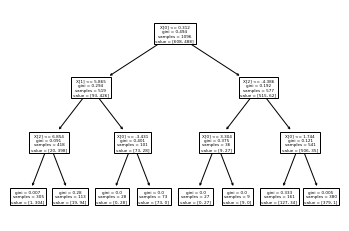

In [62]:
sp, cart = [], []
sp_depth = []
for i in tqdm(range(50)):
    sleep(3)
    #Spambase
    #data = pd.read_csv("datasets/spambase.csv")
    #X = data.to_numpy()
    #y = X[:, -1].astype(int)
    #X = X[:, 0:-1]
    
    #Banknote
    X = np.load("datasets/banknote_train.npy")
    y = np.load("datasets/banknote_label.npy")
    
    
    #Cancer
    #data = load_breast_cancer()
    #X = data.data
    #y = data.target
    
    #X = X[y!=2]
    #y = y[y!=2]
    
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = i)
    #scaler = StandardScaler()
    #X = scaler.fit_transform(X)
    #X_test = scaler.fit_transform(X_test)
    
    #CART
    clf = tree.DecisionTreeClassifier(max_depth=3, random_state=i)
    clf = clf.fit(X, y)
    tree.plot_tree(clf)  
    c_score = clf.score(X_test, y_test)
    #print(c_score)
    #print("CART test: ", c_score)
    cart.append(c_score)
    
    #Sparse
    root = train_tree(X, y, n_splits = 7)
    sp_depth.append(get_depth(root))
    #visit(root)
    preds = predict_data(X_test, root)
    sparse_score = score(preds, y_test)
    #print(sparse_score)
    #print("Sparse minimal test: ", sparse_score)
    sp.append(sparse_score)
    

print("CART: %s +- %s Sparse: %s +- %s Mean_depth: %s" % (np.mean(cart), np.std(cart), np.mean(sp), np.std(sp), np.mean(sp_depth)))